# Reto Kaggle - Traveler Insights

Miembros:
* Diederik Montaño
* Juan D. Perez

In [3]:
import pandas as pd
import numpy as np

from typing import Literal
from datetime import datetime, date

import matplotlib.pyplot as plt

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import download

import re

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


labels = [0, 1, 2]

In [4]:
download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\perez\AppData\Roaming\nltk_data...


In [5]:
def plot_confusion_matrix(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    normalize: Literal['true', 'pred', 'all'] | None = 'true'
) -> np.ndarray:
    labels = ['negativo', 'neutral', 'positivo']
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2], normalize=normalize)

    cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)
    cm_display.plot()
    plt.show()

    return cm

## Entrenamiento

In [6]:
train_df = pd.read_csv("./data/raw/train.csv")
train_df.head()

,ID,Sitio,Índice del lugar,Nombre del lugar,Enlace del lugar,Municipio,Valoración,Valoraciones,Precio,Comentario,Fecha,Votos a favor,Votos en contra,Valoración_num,Sentimiento
0,380,Tripadvisor,50,Isla Múcura,https://www.tripadvisor.co/Attraction_Review-g...,San Onofre,4.5/5,281,Precio Desconocido,La isla es muy hermosa y tiene unas aguas muy ...,24 de agosto de 2017,0,0,4.5,neutral
1,196,Foursquare,30,Doki's comidas rápidas (Majagual),https://es.foursquare.com/v/dokis-comidas-r%C3...,Sincelejo,7.4/10,13 valoraciones,$,"Lahamburguesa de polloy elpatacónDoki, son del...","Abril 12, 2015",0,0,7.4,positivo
2,723,Tripadvisor,56,Playa la Coquerita,https://www.tripadvisor.co/Attraction_Review-g...,Coveñas,4.0/5,28,Precio Desconocido,"La playa es preciosa, de aguas mansas y playas...",14 de febrero de 2020,0,0,4.0,neutral
3,522,Tripadvisor,50,Isla Múcura,https://www.tripadvisor.co/Attraction_Review-g...,San Onofre,4.5/5,281,Precio Desconocido,es un paraíso de playa Para llegar a la isla l...,3 de octubre de 2012,0,0,4.5,neutral
4,1126,Tripadvisor,74,Covenas Diving Co.,https://www.tripadvisor.co/Attraction_Review-g...,Coveñas,5.0/5,259,Precio Desconocido,Es muy buena escuela de buceo; excelente los l...,4 de marzo de 2018,0,0,5.0,neutral


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818 entries, 0 to 817
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                818 non-null    int64  
 1   Sitio             818 non-null    object 
 2   Índice del lugar  818 non-null    int64  
 3   Nombre del lugar  818 non-null    object 
 4   Enlace del lugar  817 non-null    object 
 5   Municipio         818 non-null    object 
 6   Valoración        818 non-null    object 
 7   Valoraciones      818 non-null    object 
 8   Precio            818 non-null    object 
 9   Comentario        818 non-null    object 
 10  Fecha             818 non-null    object 
 11  Votos a favor     818 non-null    int64  
 12  Votos en contra   818 non-null    int64  
 13  Valoración_num    818 non-null    float64
 14  Sentimiento       818 non-null    object 
dtypes: float64(1), int64(4), object(10)
memory usage: 96.0+ KB


### Tratar datos

Para el formato de fechas, se crearán nuevas columnas en base a ellas, además de poder cuantificar las columnas como "Sentimiento" o "Valoración", etc.

#### Sentimiento

In [8]:
train_df["Sentimiento"].unique()

array(['neutral', 'positivo', 'negativo'], dtype=object)

In [9]:
sent_id = {"neutral": 1, "positivo": 2, "negativo": 0}
train_df["Sentimiento"] = train_df["Sentimiento"].apply(lambda x: sent_id[x])
train_df["Sentimiento"].unique()

array([1, 2, 0])

#### Valoración

In [10]:
train_df["Valoración"].unique()

array(['4.5/5', '7.4/10', '4.0/5', '5.0/5', '6.8/10', '6.9/10', '7.2/10',
       '8.8/10', '3.5/5', '8.2/10', '7.7/10', '7.9/10', '8.1/10',
       '6.4/10', '7.3/10', '8.0/10', '6.7/10', '7.0/10', '7.6/10',
       '8.9/10', '7.8/10', '7.5/10', '8.7/10'], dtype=object)

In [11]:
train_df["Valoración"] = train_df["Valoración"].apply(eval)
train_df["Valoración"].unique()

array([0.9 , 0.74, 0.8 , 1.  , 0.68, 0.69, 0.72, 0.88, 0.7 , 0.82, 0.77,
       0.79, 0.81, 0.64, 0.73, 0.67, 0.76, 0.89, 0.78, 0.75, 0.87])

#### Precio

In [12]:
train_df["Precio"].unique()

array(['Precio Desconocido', '$', '$$$$', '$$'], dtype=object)

In [13]:
prices_id = {"Precio Desconocido": 0, "$": 1, "$$": 2, "$$$": 3, "$$$$": 4}
train_df["Precio"] = train_df["Precio"].apply(lambda x: prices_id[x])
train_df["Precio"].unique()


array([0, 1, 4, 2])

#### Valoraciones

In [14]:
train_df["Valoraciones"].unique()

array(['281', '13 valoraciones', '28', '259', '192', '12 valoraciones',
       '40 valoraciones', '11', '30', '34', '86', '29', '15 valoraciones',
       '51', '241 valoraciones', '32', '16 valoraciones',
       '25 valoraciones', '4', '35', '3', '15', '155 valoraciones',
       '11 valoraciones', '5', '21 valoraciones', '32 valoraciones',
       '31 valoraciones', '26 valoraciones', '12', '14 valoraciones', '6',
       '45 valoraciones', '17 valoraciones', '30 valoraciones', '2',
       '8 valoraciones', '31', '6 valoraciones', '9 valoraciones',
       '27 valoraciones', '24 valoraciones', '1'], dtype=object)

In [15]:
train_df["Valoraciones"] = train_df["Valoraciones"].apply(
    lambda x: int(x.removesuffix(" valoraciones"))
)
train_df["Valoraciones"].unique()


array([281,  13,  28, 259, 192,  12,  40,  11,  30,  34,  86,  29,  15,
        51, 241,  32,  16,  25,   4,  35,   3, 155,   5,  21,  31,  26,
        14,   6,  45,  17,   2,   8,   9,  27,  24,   1])

#### Sitio

In [16]:
train_df["Sitio"].unique()

array(['Tripadvisor', 'Foursquare'], dtype=object)

In [17]:
sites_id = {"Tripadvisor": 0, "Foursquare": 1}
train_df["Sitio"] = train_df["Sitio"].apply(lambda x: sites_id[x])
train_df["Sitio"].unique()

array([0, 1])

#### Fecha

In [18]:
def convert_date(date_str: str) -> date:
    months = {
        "enero": "January", "febrero": "February", "marzo": "March", "abril": "April",
        "mayo": "May", "junio": "June", "julio": "July", "agosto": "August",
        "septiembre": "September", "octubre": "October", "noviembre": "November",
        "diciembre": "December"
    }

    for month_es, month_en in months.items():
        date_str = date_str.lower().replace(month_es, month_en)


    # Por lo que ví, estos son los únicos dos formatos
    formats = [
        "%d de %B de %Y",
        "%B %d, %Y"
    ]

    for format in formats:
        try:
            return datetime.strptime(date_str, format).date()
        except ValueError as e:
            pass

    raise ValueError(f"No se pudo convertir la fecha: {date_str}")

train_df["Fecha"] = train_df["Fecha"].apply(convert_date)

days = []
months = []
years = []
day_of_week = []

for x in train_df["Fecha"].tolist():
    days.append(x.day)
    months.append(x.month)
    years.append(x.year)
    day_of_week.append(x.isoweekday())

train_df["day"] = days
train_df["month"] = months
train_df["year"] = years
train_df["day_of_week"] = day_of_week

train_df.head()

,ID,Sitio,Índice del lugar,Nombre del lugar,Enlace del lugar,Municipio,Valoración,Valoraciones,Precio,Comentario,Fecha,Votos a favor,Votos en contra,Valoración_num,Sentimiento,day,month,year,day_of_week
0,380,0,50,Isla Múcura,https://www.tripadvisor.co/Attraction_Review-g...,San Onofre,0.90,281,0,La isla es muy hermosa y tiene unas aguas muy ...,2017-08-24,0,0,4.5,1,24,8,2017,4
1,196,1,30,Doki's comidas rápidas (Majagual),https://es.foursquare.com/v/dokis-comidas-r%C3...,Sincelejo,0.74,13,1,"Lahamburguesa de polloy elpatacónDoki, son del...",2015-04-12,0,0,7.4,2,12,4,2015,7
2,723,0,56,Playa la Coquerita,https://www.tripadvisor.co/Attraction_Review-g...,Coveñas,0.80,28,0,"La playa es preciosa, de aguas mansas y playas...",2020-02-14,0,0,4.0,1,14,2,2020,5
3,522,0,50,Isla Múcura,https://www.tripadvisor.co/Attraction_Review-g...,San Onofre,0.90,281,0,es un paraíso de playa Para llegar a la isla l...,2012-10-03,0,0,4.5,1,3,10,2012,3
4,1126,0,74,Covenas Diving Co.,https://www.tripadvisor.co/Attraction_Review-g...,Coveñas,1.00,259,0,Es muy buena escuela de buceo; excelente los l...,2018-03-04,0,0,5.0,1,4,3,2018,7


#### Comentario

In [19]:
def preprocess_text(text: str) -> str:
    text = re.sub(r'[^a-zA-Z\sáéíóúñÁÉÍÓÚÑ]', '', text)
    text = text.lower()
    return text


train_df["Comentario"] = train_df["Comentario"].apply(preprocess_text)
train_df["Comentario"]

0      la isla es muy hermosa y tiene unas aguas muy ...
1      lahamburguesa de polloy elpatacóndoki son deli...
2      la playa es preciosa de aguas mansas y playas ...
3      es un paraíso de playa para llegar a la isla l...
4      es muy buena escuela de buceo excelente los lu...
                             ...                        
813                   lomitoa lasfinas hierbas buenisimo
814    hicimos un excelente fun dive con stefania y g...
815    el parque a su alrededor estaba en remodelació...
816    la mejor experiencia en coveñas totalmente rec...
817    a mediados de enero aún conservaba la decoraci...
Name: Comentario, Length: 818, dtype: object

In [20]:
coments = train_df["Comentario"].tolist()

# Analisis de sentimiento en base a los comentarios
negs = []
poss = []
neus = []
comps = []

for coment in coments:
    scores = sent_analyzer.polarity_scores(coment)
    negs.append(scores["neg"])
    poss.append(scores["pos"])
    neus.append(scores["neu"])
    comps.append(scores["compound"])

train_df["neg_coment"] = negs
train_df["pos_coment"] = poss
train_df["neu_coment"] = neus
train_df["compound_coment"] = comps

train_df.head()

,ID,Sitio,Índice del lugar,Nombre del lugar,Enlace del lugar,Municipio,Valoración,Valoraciones,Precio,Comentario,...,Valoración_num,Sentimiento,day,month,year,day_of_week,neg_coment,pos_coment,neu_coment,compound_coment
0,380,0,50,Isla Múcura,https://www.tripadvisor.co/Attraction_Review-g...,San Onofre,0.90,281,0,la isla es muy hermosa y tiene unas aguas muy ...,...,4.5,1,24,8,2017,4,0.000,0.000,1.000,0.0000
1,196,1,30,Doki's comidas rápidas (Majagual),https://es.foursquare.com/v/dokis-comidas-r%C3...,Sincelejo,0.74,13,1,lahamburguesa de polloy elpatacóndoki son deli...,...,7.4,2,12,4,2015,7,0.000,0.000,1.000,0.0000
2,723,0,56,Playa la Coquerita,https://www.tripadvisor.co/Attraction_Review-g...,Coveñas,0.80,28,0,la playa es preciosa de aguas mansas y playas ...,...,4.0,1,14,2,2020,5,0.103,0.069,0.829,-0.2960
3,522,0,50,Isla Múcura,https://www.tripadvisor.co/Attraction_Review-g...,San Onofre,0.90,281,0,es un paraíso de playa para llegar a la isla l...,...,4.5,1,3,10,2012,3,0.017,0.000,0.983,-0.2960
4,1126,0,74,Covenas Diving Co.,https://www.tripadvisor.co/Attraction_Review-g...,Coveñas,1.00,259,0,es muy buena escuela de buceo excelente los lu...,...,5.0,1,4,3,2018,7,0.000,0.095,0.905,0.5994


#### Dropear columnas

In [21]:
train_df.columns

Index(['ID', 'Sitio', 'Índice del lugar', 'Nombre del lugar',
       'Enlace del lugar', 'Municipio', 'Valoración', 'Valoraciones', 'Precio',
       'Comentario', 'Fecha', 'Votos a favor', 'Votos en contra',
       'Valoración_num', 'Sentimiento', 'day', 'month', 'year', 'day_of_week',
       'neg_coment', 'pos_coment', 'neu_coment', 'compound_coment'],
      dtype='object')

In [22]:
train_df.drop(columns=[
    "ID", "Fecha", "Enlace del lugar", "Nombre del lugar", "Municipio",
    "Valoración_num", "Comentario"
], inplace=True)
train_df.head()

,Sitio,Índice del lugar,Valoración,Valoraciones,Precio,Votos a favor,Votos en contra,Sentimiento,day,month,year,day_of_week,neg_coment,pos_coment,neu_coment,compound_coment
0,0,50,0.90,281,0,0,0,1,24,8,2017,4,0.000,0.000,1.000,0.0000
1,1,30,0.74,13,1,0,0,2,12,4,2015,7,0.000,0.000,1.000,0.0000
2,0,56,0.80,28,0,0,0,1,14,2,2020,5,0.103,0.069,0.829,-0.2960
3,0,50,0.90,281,0,0,0,1,3,10,2012,3,0.017,0.000,0.983,-0.2960
4,0,74,1.00,259,0,0,0,1,4,3,2018,7,0.000,0.095,0.905,0.5994


#### En una función

In [23]:
def preprocess_data(df: pd.DataFrame, drop_id: bool = True) -> pd.DataFrame:
    new_df = df.copy()

    # Tratar sentimientos
    if "Sentimiento" in df.columns:
        sent_id = {"neutral": 1, "positivo": 2, "negativo": 0}
        new_df["Sentimiento"] = df["Sentimiento"].apply(lambda x: sent_id[x])

    # Tratar la valoración
    new_df["Valoración"] = df["Valoración"].apply(eval)

    # Tratar precios
    prices_id = {"Precio Desconocido": 0, "$": 1, "$$": 2, "$$$": 3, "$$$$": 4}
    new_df["Precio"] = df["Precio"].apply(lambda x: prices_id[x])

    # Tratar valoraciones
    new_df["Valoraciones"] = df["Valoraciones"].apply(
        lambda x: int(x.removesuffix(" valoraciones"))
    )

    # Tratar los sitios
    sites_id = {"Tripadvisor": 0, "Foursquare": 1}
    new_df["Sitio"] = df["Sitio"].apply(lambda x: sites_id[x])

    # Tratar fechas
    new_df["Fecha"] = df["Fecha"].apply(convert_date)

    days = []
    months = []
    years = []
    day_of_week = []

    for x in new_df["Fecha"].tolist():
        days.append(x.day)
        months.append(x.month)
        years.append(x.year)
        day_of_week.append(x.isoweekday())

    new_df["day"] = days
    new_df["month"] = months
    new_df["year"] = years
    new_df["day_of_week"] = day_of_week

    # Tratar comentarios
    new_df["Comentario"] = df["Comentario"].apply(preprocess_text)
    coments = new_df["Comentario"].tolist()

    negs = []
    poss = []
    neus = []
    comps = []

    for coment in coments:
        scores = sent_analyzer.polarity_scores(coment)
        negs.append(scores["neg"])
        poss.append(scores["pos"])
        neus.append(scores["neu"])
        comps.append(scores["compound"])

    new_df["neg_coment"] = negs
    new_df["pos_coment"] = poss
    new_df["neu_coment"] = neus
    new_df["compound_coment"] = comps

    # Dropear columnas
    new_df.drop(columns=[
        "Fecha", "Enlace del lugar", "Nombre del lugar", "Municipio",
        "Valoración_num", "Comentario"
    ], inplace=True)

    if drop_id:
        new_df.drop(columns=["ID"], inplace=True)

    return new_df

### Resultado

In [79]:
train_df

,Sitio,Índice del lugar,Valoración,Valoraciones,Precio,Votos a favor,Votos en contra,Sentimiento,day,month,year,day_of_week,neg_coment,pos_coment,neu_coment,compound_coment
0,0,50,0.90,281,0,0,0,1,24,8,2017,4,0.000,0.000,1.000,0.0000
1,1,30,0.74,13,1,0,0,2,12,4,2015,7,0.000,0.000,1.000,0.0000
2,0,56,0.80,28,0,0,0,1,14,2,2020,5,0.103,0.069,0.829,-0.2960
3,0,50,0.90,281,0,0,0,1,3,10,2012,3,0.017,0.000,0.983,-0.2960
4,0,74,1.00,259,0,0,0,1,4,3,2018,7,0.000,0.095,0.905,0.5994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,1,4,0.87,24,4,0,0,2,20,4,2014,7,0.000,0.000,1.000,0.0000
814,0,75,1.00,192,0,0,0,1,2,7,2023,7,0.000,0.073,0.927,0.5106
815,0,59,0.80,30,0,0,0,1,5,1,2015,1,0.000,0.000,1.000,0.0000
816,0,74,1.00,259,0,0,0,1,23,8,2022,2,0.000,0.000,1.000,0.0000


In [24]:
preprocess_data(pd.read_csv("./data/raw/train.csv"))

,Sitio,Índice del lugar,Valoración,Valoraciones,Precio,Votos a favor,Votos en contra,Sentimiento,day,month,year,day_of_week,neg_coment,pos_coment,neu_coment,compound_coment
0,0,50,0.90,281,0,0,0,1,24,8,2017,4,0.000,0.000,1.000,0.0000
1,1,30,0.74,13,1,0,0,2,12,4,2015,7,0.000,0.000,1.000,0.0000
2,0,56,0.80,28,0,0,0,1,14,2,2020,5,0.103,0.069,0.829,-0.2960
3,0,50,0.90,281,0,0,0,1,3,10,2012,3,0.017,0.000,0.983,-0.2960
4,0,74,1.00,259,0,0,0,1,4,3,2018,7,0.000,0.095,0.905,0.5994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,1,4,0.87,24,4,0,0,2,20,4,2014,7,0.000,0.000,1.000,0.0000
814,0,75,1.00,192,0,0,0,1,2,7,2023,7,0.000,0.073,0.927,0.5106
815,0,59,0.80,30,0,0,0,1,5,1,2015,1,0.000,0.000,1.000,0.0000
816,0,74,1.00,259,0,0,0,1,23,8,2022,2,0.000,0.000,1.000,0.0000


### Graficar

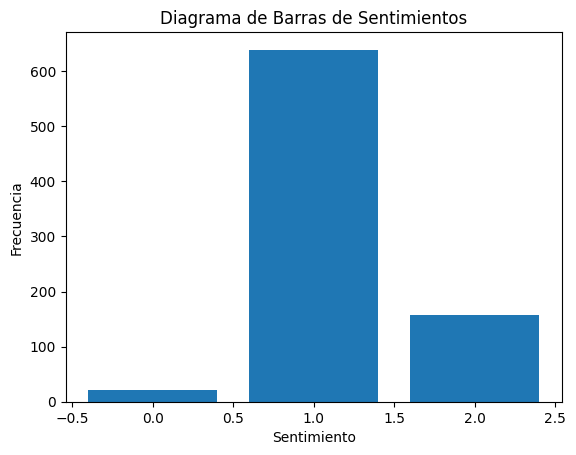

In [25]:
sent_counts = train_df["Sentimiento"].value_counts().sort_index()
plt.bar(sent_counts.index, sent_counts.values)

plt.title('Diagrama de Barras de Sentimientos')

plt.xlabel('Sentimiento')
plt.ylabel('Frecuencia')

plt.show()

### Modelo

In [26]:
x_train = train_df.drop(columns=["Sentimiento"]).to_numpy()
y_train = train_df["Sentimiento"].to_numpy()

#### SVC - Linear

In [27]:
svc_linear = LinearSVC(random_state=42, dual=False)
svc_linear.fit(x_train, y_train)

LinearSVC(dual=False, random_state=42)

In [33]:
svc_linear_pred = svc_linear.predict(x_train)

print(f'Accuracy: {accuracy_score(y_train, svc_linear_pred)}')
print(f'Precision: {precision_score(y_train, svc_linear_pred, average=None, labels=labels)}')
print(f'Recall: {recall_score(y_train, svc_linear_pred, average=None, labels=labels)}')
print(f'F1-score: {f1_score(y_train, svc_linear_pred, average=None, labels=labels)} - Media ponderada {f1_score(y_train, svc_linear_pred, average="weighted")}')

Accuracy: 0.9731051344743277
Precision: [0.        0.9667171 1.       ]
Recall: [0. 1. 1.]
F1-score: [0.         0.98307692 1.        ] - Media ponderada 0.9598852736505549


c:\Users\perez\Documents\vscode\IA parcial\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Test

In [35]:
test_df = pd.read_csv("./data/raw/test.csv")
test_df

,ID,Sitio,Índice del lugar,Nombre del lugar,Enlace del lugar,Municipio,Valoración,Valoraciones,Precio,Comentario,Fecha,Votos a favor,Votos en contra,Valoración_num,Sentimiento
0,56,Foursquare,2,Playas de Coveñas,https://es.foursquare.com/v/playas-de-cove%C3%...,Coveñas,8.8/10,241 valoraciones,Precio Desconocido,Un lugar para vacacionar? Coveñas es relax total!,"Noviembre 3, 2012",4,0,8.8,positivo
1,1083,Tripadvisor,74,Covenas Diving Co.,https://www.tripadvisor.co/Attraction_Review-g...,Coveñas,5.0/5,259,Precio Desconocido,De regalo del Día del Padre me regalaron esta ...,5 de julio de 2019,2,0,5.0,neutral
2,262,Foursquare,43,Nonnina Pizza,https://foursquare.com/v/nonnina-pizza/4d17ec0...,Sincelejo,6.8/10,12 valoraciones,$,"Recomiendo las pastas con tocineta, son realme...","Enero 15, 2014",0,0,6.8,neutral
3,447,Tripadvisor,50,Isla Múcura,https://www.tripadvisor.co/Attraction_Review-g...,San Onofre,4.5/5,281,Precio Desconocido,"Increíble! Precioso lugar para descansar, muy ...",20 de febrero de 2015,0,0,4.5,neutral
4,59,Foursquare,2,Playas de Coveñas,https://es.foursquare.com/v/playas-de-cove%C3%...,Coveñas,8.8/10,241 valoraciones,Precio Desconocido,Muy bueno deli .,"Noviembre 21, 2013",1,0,8.8,positivo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,874,Tripadvisor,64,Plaza de Majagual,https://www.tripadvisor.co/Attraction_Review-g...,Sincelejo,3.5/5,32,Precio Desconocido,Una plaza muy típica de ciudades intermedias c...,28 de abril de 2015,0,0,3.5,negativo
347,148,Foursquare,21,Javier Parrilla,https://es.foursquare.com/v/javier-parrilla/4e...,Sincelejo,7.7/10,25 valoraciones,$$,"Recomiendo elchurrasco argentino, es delicioso!","Septiembre 27, 2013",0,0,7.7,positivo
348,982,Tripadvisor,74,Covenas Diving Co.,https://www.tripadvisor.co/Attraction_Review-g...,Coveñas,5.0/5,259,Precio Desconocido,Excelente trato y paciencia de parte de Guille...,27 de abril de 2021,0,0,5.0,neutral
349,1080,Tripadvisor,74,Covenas Diving Co.,https://www.tripadvisor.co/Attraction_Review-g...,Coveñas,5.0/5,259,Precio Desconocido,¡Seguro que muy pronto lo harás!,5 de agosto de 2019,1,0,5.0,neutral


In [36]:
test_df = preprocess_data(test_df)
test_df

,Sitio,Índice del lugar,Valoración,Valoraciones,Precio,Votos a favor,Votos en contra,Sentimiento,day,month,year,day_of_week,neg_coment,pos_coment,neu_coment,compound_coment
0,1,2,0.88,241,0,4,0,2,3,11,2012,6,0.0,0.293,0.707,0.4404
1,0,74,1.00,259,0,2,0,1,5,7,2019,5,0.0,0.000,1.000,0.0000
2,1,43,0.68,12,1,0,0,1,15,1,2014,3,0.0,0.000,1.000,0.0000
3,0,50,0.90,281,0,0,0,1,20,2,2015,5,0.0,0.000,1.000,0.0000
4,1,2,0.88,241,0,1,0,2,21,11,2013,4,0.0,0.000,1.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,0,64,0.70,32,0,0,0,0,28,4,2015,2,0.0,0.000,1.000,0.0000
347,1,21,0.77,25,2,0,0,2,27,9,2013,5,0.0,0.000,1.000,0.0000
348,0,74,1.00,259,0,0,0,1,27,4,2021,2,0.0,0.000,1.000,0.0000
349,0,74,1.00,259,0,1,0,1,5,8,2019,1,0.0,0.000,1.000,0.0000


### Modelos

In [37]:
x_test = test_df.drop(columns=["Sentimiento"]).to_numpy()
y_test = test_df["Sentimiento"].to_numpy()

#### SVC - Linear

In [38]:
svc_linear_pred = svc_linear.predict(x_test)

print(f'Accuracy: {accuracy_score(y_test, svc_linear_pred)}')
print(f'Precision: {precision_score(y_test, svc_linear_pred, average=None, labels=labels)}')
print(f'Recall: {recall_score(y_test, svc_linear_pred, average=None, labels=labels)}')
print(f'F1-score: {f1_score(y_test, svc_linear_pred, average=None, labels=labels)} - Media ponderada {f1_score(y_test, svc_linear_pred, average="weighted")}')

Accuracy: 0.9715099715099715
Precision: [0.         0.96478873 1.        ]
Recall: [0. 1. 1.]
F1-score: [0.         0.98207885 1.        ] - Media ponderada 0.9575202442585955


c:\Users\perez\Documents\vscode\IA parcial\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


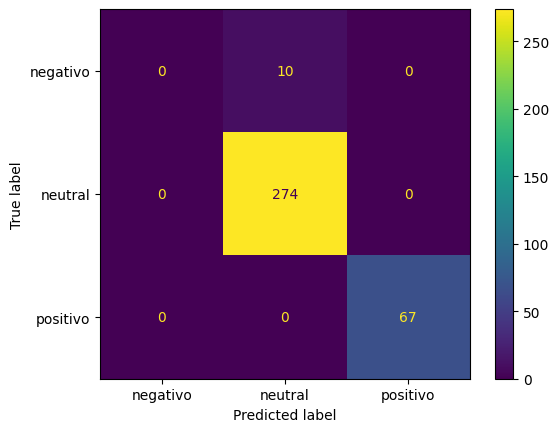

array([[  0,  10,   0],
       [  0, 274,   0],
       [  0,   0,  67]])

In [39]:
plot_confusion_matrix(y_test, svc_linear_pred, None)

## Submissions

In [44]:
submit_df = pd.read_csv("./data/raw/submission.csv").drop(columns=["Sentimiento"])
submit_df

,ID,Sitio,Índice del lugar,Nombre del lugar,Enlace del lugar,Municipio,Valoración,Valoraciones,Precio,Comentario,Fecha,Votos a favor,Votos en contra,Valoración_num
0,980,Tripadvisor,74,Covenas Diving Co.,https://www.tripadvisor.co/Attraction_Review-g...,Coveñas,5.0/5,259,Precio Desconocido,"De las mejores experiencias de la vida, no se ...",25 de abril de 2021,0,0,5.0
1,1249,Tripadvisor,79,Anfibio Sports Adventure,https://www.tripadvisor.co/Attraction_Review-g...,San Onofre,5.0/5,34,Precio Desconocido,Me encanto el plan de Stand up paddle y de bic...,1 de julio de 2021,0,0,5.0
2,260,Foursquare,42,Playas De La Primera Ensenada,https://foursquare.com/v/playas-de-la-primera-...,Coveñas,6.9/10,9 valoraciones,Precio Desconocido,Excelentes playas para disfrutar del hermoso m...,"Abril 13, 2013",0,0,6.9
3,459,Tripadvisor,50,Isla Múcura,https://www.tripadvisor.co/Attraction_Review-g...,San Onofre,4.5/5,281,Precio Desconocido,"Experiencia inolvidable Es un paisaje exótico,...",7 de enero de 2015,0,0,4.5
4,309,Foursquare,48,Lile's Pizza,https://foursquare.com/v/liles-pizza/5185a7cb4...,Sincelejo,6.7/10,31 valoraciones,$,Excelente la caprichosa y los granizados ;),"Septiembre 19, 2013",0,0,6.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,139,Foursquare,17,Guacarí - Parque Comercial,https://es.foursquare.com/v/guacar%C3%AD--parq...,Sincelejo,7.9/10,11 valoraciones,Precio Desconocido,FullAire Acondicionado👌🏻,"Abril 13, 2019",0,0,7.9
125,117,Foursquare,11,CrepesPin Restaurante,https://es.foursquare.com/v/crepespin-restaura...,Sincelejo,8.0/10,26 valoraciones,Precio Desconocido,Lalasagna de berenjenaes una locura 😳la atenci...,"Mayo 10, 2014",0,0,8.0
126,234,Foursquare,38,Plaza de Majagual,https://foursquare.com/v/plaza-de-majagual/4c0...,Sincelejo,7.2/10,40 valoraciones,Precio Desconocido,"Vista Aérea Plaza Majagual, link: http://goo.g...","Febrero 11, 2012",0,0,7.2
127,981,Tripadvisor,74,Covenas Diving Co.,https://www.tripadvisor.co/Attraction_Review-g...,Coveñas,5.0/5,259,Precio Desconocido,Es una experiencia única para conectarte con l...,26 de abril de 2021,0,0,5.0


In [45]:
submit_df = preprocess_data(submit_df, False)
submit_df

,ID,Sitio,Índice del lugar,Valoración,Valoraciones,Precio,Votos a favor,Votos en contra,day,month,year,day_of_week,neg_coment,pos_coment,neu_coment,compound_coment
0,980,0,74,1.00,259,0,0,0,25,4,2021,7,0.081,0.000,0.919,-0.2960
1,1249,0,79,1.00,34,0,0,0,1,7,2021,4,0.044,0.078,0.878,0.4019
2,260,1,42,0.69,9,0,0,0,13,4,2013,6,0.000,0.000,1.000,0.0000
3,459,0,50,0.90,281,0,0,0,7,1,2015,3,0.000,0.000,1.000,0.0000
4,309,1,48,0.67,31,1,0,0,19,9,2013,4,0.000,0.000,1.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,139,1,17,0.79,11,0,0,0,13,4,2019,6,0.000,0.000,1.000,0.0000
125,117,1,11,0.80,26,0,0,0,10,5,2014,6,0.000,0.000,1.000,0.0000
126,234,1,38,0.72,40,0,0,0,11,2,2012,6,0.000,0.000,1.000,0.0000
127,981,0,74,1.00,259,0,0,0,26,4,2021,1,0.000,0.000,1.000,0.0000


In [46]:
x = submit_df.drop(columns=["ID"]).to_numpy()
pred_y = svc_linear.predict(x)

In [47]:
pred_df = pd.DataFrame({"ID": submit_df["ID"], "Sentimiento": pred_y})
pred_df

,ID,Sentimiento
0,980,1
1,1249,1
2,260,1
3,459,1
4,309,1
...,...,...
124,139,2
125,117,2
126,234,2
127,981,1


In [48]:
pred_df.to_csv("./data/prediction/pred.csv", index=False)